In [203]:
import pandas as pd
import pycaret
from pycaret.classification import *

In [204]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv2.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_stress_sema'].notna()]
df = df.drop(columns=['label_panas_negative_affect', 'label_stai_stress'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,bmi,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_stress_sema
1,621e30e467b776a240e817c7,33.274919,52.5365,38.1610,94.5,17.2,72.0,0.733333,0.7,0.700000,...,3,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,1.0
6,621e32af67b776a24045b4cf,34.119702,51.6220,43.5360,97.8,13.8,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
8,621e301e67b776a240608a72,34.710232,62.3900,34.0570,96.0,15.0,74.0,0.700000,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
9,621e337667b776a240ce78ab,33.662874,52.9270,39.9390,95.5,11.2,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
17,621e2f7a67b776a240f14425,32.556993,62.3900,34.0570,96.7,15.0,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,621e33cf67b776a240087de9,33.892631,62.8590,49.3950,96.0,12.0,72.0,0.733333,0.7,0.766667,...,2,0.866025,-0.781831,0.587785,-0.101168,0.5,0.62349,0.809017,-0.994869,1.0
4888,621e346f67b776a24081744f,32.903545,71.8630,25.4750,96.0,18.2,72.0,0.733333,0.7,0.733333,...,3,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,1.0
4891,621e2f9167b776a240011ccb,34.716690,58.4890,28.3290,96.5,14.2,72.0,0.733333,0.7,0.700000,...,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,1.0
4900,621e331067b776a24085dd3f,34.683800,62.3900,34.0570,96.0,15.0,72.0,0.733333,0.7,0.700000,...,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,0.0


In [205]:
df['label_stress_sema'].value_counts()

0.0    1750
1.0     496
Name: label_stress_sema, dtype: int64

In [206]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.id.isin(users_train)], data[data.id.isin(users_test)]

In [207]:
train_data, test_data = train_test_split_per_user(df)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [223]:
s = setup(data=train_data, 
          target='label_stress_sema', 
          session_id=123, 
          fold_strategy='groupkfold', 
          fold=3,  
          fold_groups=fold_groups,  
          test_data=test_data,
          normalize=True,
          fix_imbalance=True) 

,Description,Value
0,Session id,123
1,Target,label_stress_sema
2,Target type,Binary
3,Original data shape,"(2246, 43)"
4,Transformed data shape,"(3080, 42)"
5,Transformed train set shape,"(2314, 42)"
6,Transformed test set shape,"(766, 42)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


In [224]:
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.4202,0.4964,0.6058,0.2118,0.3112,-0.0139,-0.0204,0.0467
lr,Logistic Regression,0.5845,0.4944,0.3721,0.2187,0.2688,0.0086,0.0134,0.0567
lda,Linear Discriminant Analysis,0.5689,0.4889,0.3775,0.2095,0.2627,-0.0060,-0.0010,0.0267
ridge,Ridge Classifier,0.5669,0.0000,0.3714,0.2070,0.2585,-0.0106,-0.0063,0.0167
svm,SVM - Linear Kernel,0.5723,0.0000,0.3328,0.2033,0.2518,-0.0254,-0.0266,0.0267
nb,Naive Bayes,0.5967,0.4820,0.2937,0.2004,0.2365,-0.0297,-0.0310,0.0200
dt,Decision Tree Classifier,0.6183,0.4601,0.1807,0.1628,0.1701,-0.0759,-0.0763,0.0300
ada,Ada Boost Classifier,0.6912,0.5024,0.1096,0.1726,0.1266,-0.0380,-0.0413,0.1033
xgboost,Extreme Gradient Boosting,0.7291,0.4756,0.0809,0.2237,0.1156,-0.0084,-0.0052,0.2567
qda,Quadratic Discriminant Analysis,0.7399,0.4746,0.0717,0.1988,0.1033,-0.0071,-0.0102,0.0233


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [225]:
algo = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4575,0.5031,0.5615,0.2570,0.3527,-0.0131,-0.0162
1,0.4097,0.5042,0.5952,0.1629,0.2558,-0.0161,-0.0257
2,0.3935,0.4818,0.6606,0.2156,0.3251,-0.0125,-0.0193
Mean,0.4202,0.4964,0.6058,0.2118,0.3112,-0.0139,-0.0204
Std,0.0272,0.0103,0.0411,0.0385,0.0408,0.0016,0.0040


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [226]:
print(algo)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [227]:
tuned_algo = tune_model(algo)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6275,0.4955,0.2692,0.2823,0.2756,0.0251,0.0251
1,0.6471,0.5341,0.3095,0.1831,0.2301,0.0203,0.0215
2,0.5639,0.4647,0.4220,0.2323,0.2997,0.0203,0.0222
Mean,0.6128,0.4981,0.3336,0.2326,0.2685,0.0219,0.0229
Std,0.0355,0.0284,0.0647,0.0405,0.0289,0.0023,0.0016


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [216]:
print(tuned_algo)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='uniform')


In [217]:
plot_model(tuned_algo, plot='feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

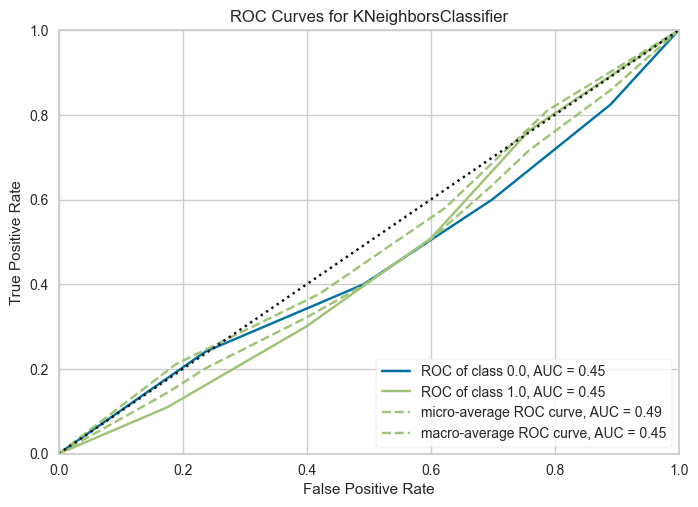

In [218]:
plot_model(tuned_algo, plot = 'auc')

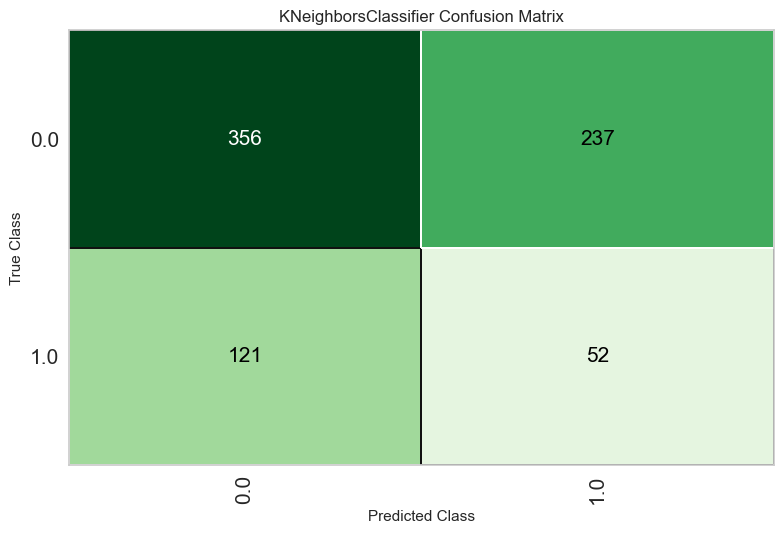

In [219]:
plot_model(tuned_algo, plot = 'confusion_matrix')

In [220]:
# Predict on test / hold-out Sample
test_predictions = predict_model(tuned_algo, data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.5326,0.4502,0.3006,0.1799,0.2251,-0.0801,-0.0855
